In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.data_utils import DataLoader
import random
import os

2024-03-18 23:44:46.233851: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 23:44:46.253833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 23:44:46.253881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 23:44:46.253900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 23:44:46.258083: I tensorflow/core/platform/cpu_feature_g

In [2]:
cfg = {}
cfg['data'] = {}
cfg['data']['name'] = 'custom'
cfg['data']['labels'] = {}
cfg['data']['labels']['name'] = ['Nam Joo-hyuk', 'Kim Da-mi', 'Kim Seong-cheol', 
                                 'Yoo Jae-suk', 'Kim Tae-ri', 'Choi Woo-shik']
# cfg['data']['labels']['name']=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
#        'bus', 'car', 'cat', 'chair', 'cow', 
#        'diningtable', 'dog', 'horse', 'motorbike', 'person', 
#        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cfg['batch_size'] = 4
cfg['model'] = {}
cfg['model']['anchors'] = np.zeros((3,3,2))
cfg['data']['labels']['count'] = 6
cfg['model']['input_size'] = np.array([512, 512])
cfg['seed'] = 42
cfg['data']['max_bboxes'] = 100
cfg['aug'] = {'mosaic':0, 'scale':1.0, 'rotate90':1.0,
              'flip_horizontally':0.5, 'crop':1.0,
              'gaussian_blur':0.3, 'brightness':0.5,
              'hue':0.5, 'saturation':0.5, 'contrast':0.5}
# cfg['batch_size'] *= cfg['aug']['mosaic']

# os.environ['PYTHONASHSEED']=str(cfg['seed'])
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(cfg['seed'])
tf.random.set_seed(cfg['seed'])
tf.keras.utils.set_random_seed(cfg['seed'])
# tf.config.experimental.enable_op_determinism()
np.random.seed(cfg['seed'])

In [3]:
dataloader = DataLoader(cfg)
train_dataset = dataloader('train', cfg['batch_size'], aug=cfg['aug'])
val_dataset = dataloader('val')

data = []
for e in range(1):
    for i, (batch_images, batch_labels) in enumerate(train_dataset):
        data += [[batch_images,batch_labels]]
        if i==0:
            break

2024-03-18 23:44:47.261527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Dataset: custom train
./data/custom/train.tfrecord is exist


2024-03-18 23:44:47.276303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 23:44:47.276400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 23:44:47.277282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Dataset: custom val
./data/custom/val.tfrecord is exist


2024-03-18 23:44:48.943354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Subshape end out of bounds: -4, for shape with rank 3
2024-03-18 23:44:49.230899: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


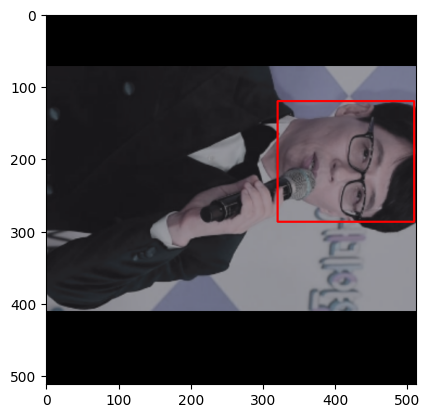

In [4]:
"""
1. crop, resize_padding
2. mosaic 구현
3. rotate90, color_method, gaussian filter size 변경
4. 재현성 확인
"""
b=0
idx = 0
image =(data[b][0][idx].numpy()*255).astype(np.uint8)
labels = data[b][1]
labels = labels[labels[..., 0] == idx].numpy().astype(np.int32)

for i, x1, y1, x2, y2, c in labels:
    cv2.rectangle(image, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image)
plt.show() 

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


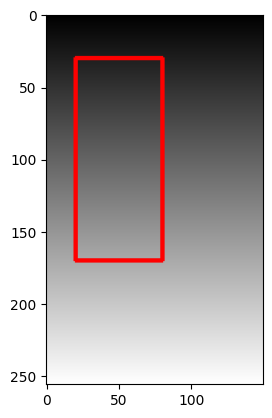

In [17]:
image = np.array([np.zeros((150,3), np.float32)+i for i in range(256)])
labels = np.array([[20,30,80,170,0.]])

image_ = image.copy()
for x1, y1, x2, y2, c in labels.astype(np.int32):
    cv2.rectangle(image_, [x1,y1],[x2,y2], [255, 0,0], 2)
plt.imshow((image_).astype(np.uint8))
plt.show()

7


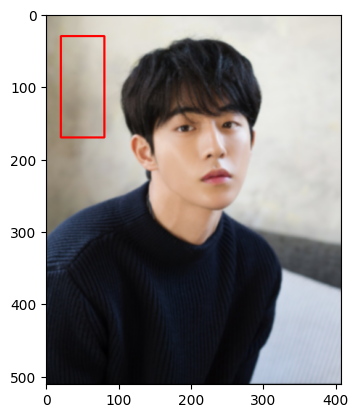

In [119]:
def rotate90(iimage, llabels, seed=42):
    def rotate90_bboxes(lllabels, width, height):
        if tf.reduce_sum(lllabels) != 0:
            lllabels = tf.stack([lllabels[..., 1],
                                width - lllabels[..., 2] -1,
                                lllabels[..., 3],
                                width - lllabels[..., 0] -1,
                                lllabels[..., 4]], -1)
        return lllabels, height, width
    
    times = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32, seed=seed)
    size = tf.cast(tf.shape(iimage)[-2:-4:-1], tf.float32)
    width, height = size[0], size[1]
    for time in tf.range(times):
        size = tf.shape(iimage)[-2:-4:-1]
        llabels, width, height = rotate90_bboxes(llabels, width, height)
    return tf.image.rot90(iimage, times), tf.constant(llabels)
def resize(image, out_size):
    size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)
    ratio = out_size/tf.reduce_max(size)
    new_size = tf.cast(ratio * size, tf.int32)
    resized_image = tf.image.resize(image, tf.cast(new_size, tf.int32)[::-1])
    mult = tf.stack([*tf.unstack(ratio),*tf.unstack(ratio),1.])

    return resized_image
image = cv2.imread('data/custom/train/JPEGImages/1.jpg').astype(np.float32)[..., ::-1]
image = resize(image, tf.stack([512.,512.]))
def gaussian_blur(imagei, labels, ksize=3, sigma=1, seed=42):
    idx = tf.random.uniform((), minval=0, maxval=6, dtype=tf.int32, seed=seed)
    ksize = [3, 5, 7, 9, 11, 13][idx]

    def gaussian_kernel(size=3, sigma=1):
        x_range = tf.range(-(size-1)//2, (size-1)//2 + 1, 1)
        y_range = tf.range((size-1)//2, -(size-1)//2 - 1, -1)

        xs, ys = tf.meshgrid(x_range, y_range)
        kernel = tf.exp(-(xs**2 + ys**2) / (2*(sigma**2))) / (2*np.pi*(sigma**2))
        return tf.cast(kernel / tf.reduce_sum(kernel), tf.float32)
    kernel = gaussian_kernel(ksize, sigma)[..., None, None]
    
    r, g, b = tf.split(imagei, [1,1,1], -1)
    r_blur = tf.nn.conv2d(r[None], kernel, [1,1,1,1], 'SAME')
    g_blur = tf.nn.conv2d(g[None], kernel, [1,1,1,1], 'SAME')
    b_blur = tf.nn.conv2d(b[None], kernel, [1,1,1,1], 'SAME')

    blur_image = tf.concat([r_blur, g_blur, b_blur], -1)[0]
    return blur_image, labels
image = image
image2, labels2 = gaussian_blur(tf.constant(image), tf.constant(labels), 13)
image_ = image2.numpy().copy()
labels2 = labels2.numpy()
for x1, y1, x2, y2, c in labels2.astype(np.int32):
    cv2.rectangle(image_, [x1,y1],[x2,y2], [255, 0,0], 2)
plt.imshow((image_).astype(np.uint8))
plt.show()

In [94]:
image.shape

(1505, 1200, 3)

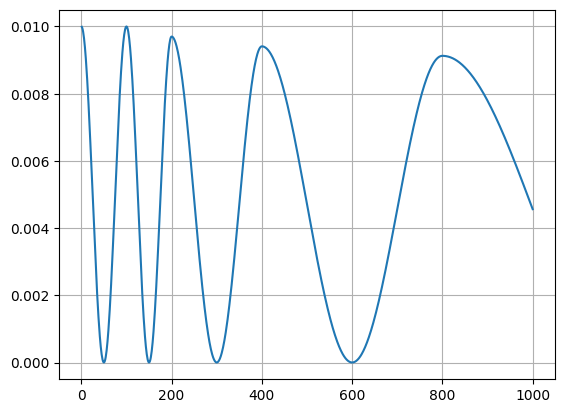

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from utils.lr_shcedulers import LR_scheduler

with open('yaml/config.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg['train']['lr_scheduler']['name'] = 'custom'
cfg['train']['lr_scheduler']['warmup_epochs']=0

epochs=1
step_per_epoch = 1000
lr_scheduler = LR_scheduler(cfg['train']['lr_scheduler'], epochs, step_per_epoch)

steps = []
lrs = []
for epoch in range(1, epochs+1):
    for step in range((epoch-1)*step_per_epoch+1, epoch*step_per_epoch+1):
        steps += [step]
        lrs += [lr_scheduler(step)]

plt.plot(steps, lrs)
plt.grid(True)

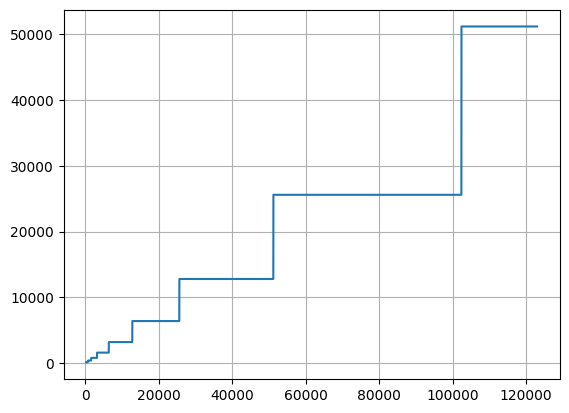

In [2]:
plt.plot(steps, t)
plt.grid(True)

In [15]:
lrs[-1]

4.99999999999945e-06

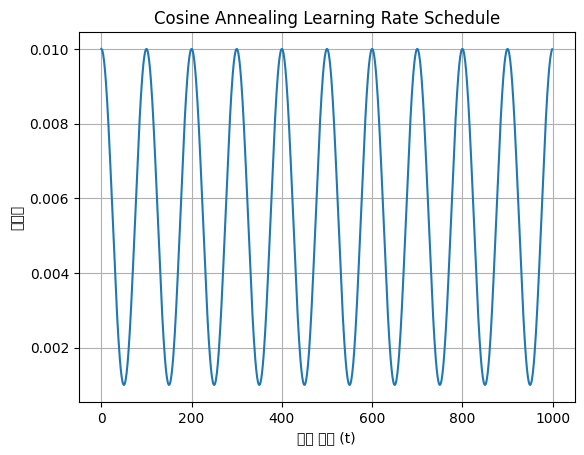

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 1000, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 주기

lr_values = cosine_annealing(t_values, min_lr, max_lr, t_max)

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


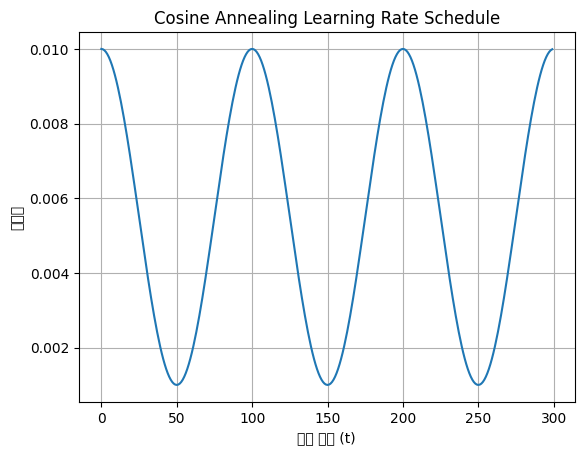

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 300, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 초기 주기
t_max_increment = 0.00  # 주기 증가량

lr_values = []
for t in t_values:
    lr_values.append(cosine_annealing(t, min_lr, max_lr, t_max))
    if t % t_max == 0 and t != 0:
        t_max += t_max * t_max_increment  # 주기를 조금씩 증가시킴

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


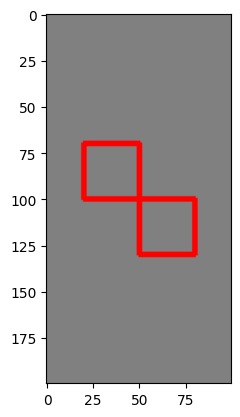

In [1]:
import tensorflow as tf
from utils.aug_utils import resize_padding, resize, resize_padding_without_labels
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = np.zeros((200,100,3), np.float32) + 128
labels = np.array([[20,70,50,100,0],[50,100,80,130,0]], np.float32)
image_ = image.astype(np.uint8)
for x1,y1,x2,y2,c in labels.astype(np.int32):
    cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

2024-03-15 10:27:19.748345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.769986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.770203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-15 10:27:19.770790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

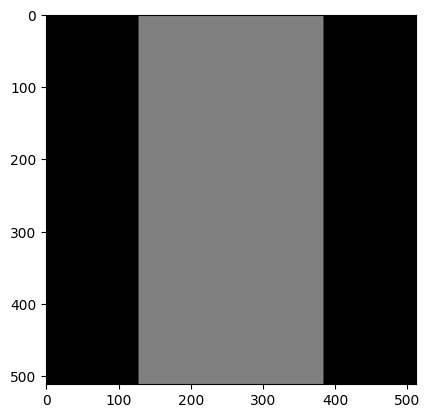

In [2]:
imager, labelsr = resize_padding_without_labels(image, tf.constant([512, 512], tf.float32))
image_ = imager.numpy().astype(np.uint8)
# for x1,y1,x2,y2,c in labelsr.numpy().astype(np.int32):
#     cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

In [25]:
def crop(image, labels, xyxy=None, seed=42):
    if xyxy is None:
        size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)
        x1, y1 = tf.unstack(tf.cast(tf.random.uniform([2], minval=[0,0], maxval=size//3, seed=seed), tf.int32))
        x2, y2 = tf.unstack(tf.cast(tf.random.uniform([2], minval=size//3*2, maxval=size, seed=seed), tf.int32))
    else:
        x1, y1, x2, y2 = tf.unstack(xyxy)
    
    crop_image = image[y1:y2, x1:x2]
    flag = tf.logical_and(tf.reduce_all(labelsr[..., 2:4] > [x1, y1], -1),
                           tf.reduce_all(labelsr[..., :2] < [x2, y2], -1))
    filtered_labels = labels[flag]
    crop_labels = tf.concat([tf.maximum(filtered_labels[..., :2] - [x1, y1], 0),
                             filtered_labels[..., 2:4] - [x1, y1] - tf.maximum(filtered_labels[..., 2:4] - [x2, y2], 0),
                             filtered_labels[..., 4:]], -1)
    return crop_image, crop_labels

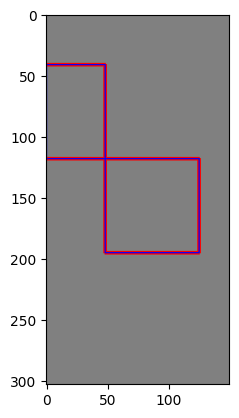

In [37]:
xyxy = np.array([100, 50, 300, 150])
imagec, labelsc = crop(image_, labelsr)
imagecc = imagec.astype(np.uint8)
for x1, y1, x2, y2, c in labelsc.numpy().astype(np.int32):
    cv2.rectangle(imagecc, [x1,y1], [x2,y2], [0, 0, 255], 1)
plt.imshow(imagecc)
plt.show()

In [12]:
imager[y1:y2, x1:x2].shape

TensorShape([77, 77, 3])

tf.Tensor(150, shape=(), dtype=int32) tf.Tensor(40, shape=(), dtype=int32) tf.Tensor(256, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)


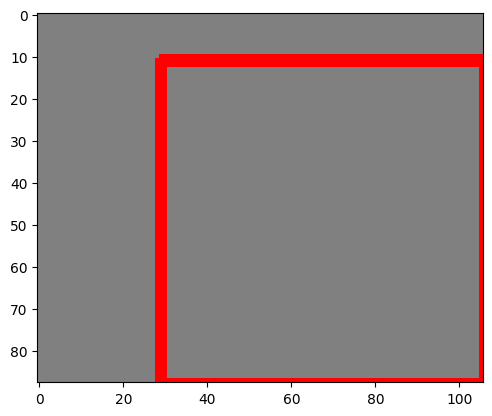

In [37]:

image_ = imagec.astype(np.uint8)
plt.imshow(image_)
plt.show()

In [12]:
import time
import tensorflow as tf
q=tf.constant([1])

In [58]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for _ in range(3):
        a=f[i]
        b+=[a]
c=tf.concat([b],0)
d += [tf.concat([tf.zeros(c.shape[:-1], dtype=tf.float32)[..., None]+idx, c], -1)]

time.time()-st, tf.concat(d, 0).shape

(0.0067901611328125, TensorShape([3, 6]))

In [59]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for i in range(3):
        a=f[i]
        b+=[tf.concat([tf.zeros(a.shape[:-1], dtype=tf.float32)[..., None]+idx, a], -1)]
c=tf.concat([b],0)
d += [c]

time.time()-st, tf.concat(d, 0).shape

(0.013540029525756836, TensorShape([3, 6]))

In [2]:
import numpy as np

In [10]:
a=np.zeros((1,2,3,4))
s=len(a.shape)
a.shape[s-3:]

(2, 3, 4)